
🚀 Starting preprocessing for 20 COCO2017 images...



Processing images: 100%|██████████████████████████| 20/20 [00:13<00:00,  1.52it/s]



✅ Completed preprocessing of 20 images in 13.14 seconds.


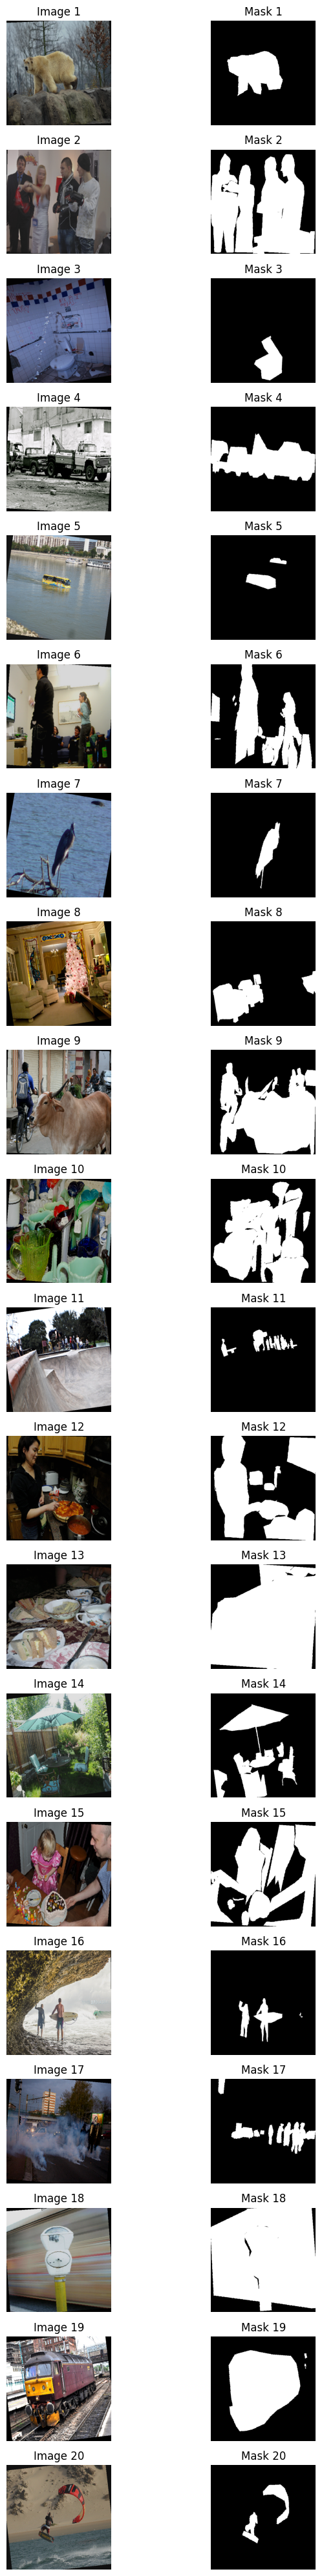


🟢 Task 2 – Data Preprocessing and Validation complete!


In [11]:
import time, os, json, random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from tqdm import tqdm

# ============================
# CONFIGURATION
# ============================
BASE_DIR = r"D:\COCO2017"
IMG_DIR = os.path.join(BASE_DIR, "train2017")
ANN_FILE = os.path.join(BASE_DIR, "annotations", "instances_train2017.json")

if not os.path.exists(IMG_DIR) or not os.path.exists(ANN_FILE):
    raise FileNotFoundError("❌ Dataset not found. Please verify D:\\COCO2017 structure.")

# ============================
# LOAD ANNOTATIONS
# ============================
with open(ANN_FILE, "r") as f:
    coco_data = json.load(f)

images_info = {img["id"]: img for img in coco_data["images"]}
annotations = coco_data["annotations"]

# ============================
# CREATE MASK FUNCTION
# ============================
def create_mask(img_id, width, height):
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann["image_id"] == img_id:
            segs = ann.get("segmentation", [])
            if isinstance(segs, list):
                for seg in segs:
                    if len(seg) > 4:
                        poly = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
                        draw.polygon(poly, outline=1, fill=1)
    return mask

# ============================
# TRANSFORMS
# ============================
image_transform = T.Compose([
    T.Resize((450, 450)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

mask_transform = T.Compose([
    T.Resize((450, 450)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
])

# ============================
# DATASET CLASS
# ============================
class CocoPreprocessDataset(Dataset):
    def __init__(self, img_dir, img_info, transform_img=None, transform_mask=None, sample_size=20):
        self.img_dir = img_dir
        self.img_info = random.sample(list(img_info.values()), min(sample_size, len(img_info)))
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.img_info)

    def __getitem__(self, idx):
        img_data = self.img_info[idx]
        img_path = os.path.join(self.img_dir, img_data["file_name"])
        image = Image.open(img_path).convert("RGB")
        mask = create_mask(img_data["id"], img_data["width"], img_data["height"])

        seed = torch.seed()
        torch.manual_seed(seed)
        if self.transform_img:
            image = self.transform_img(image)
        torch.manual_seed(seed)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return image, mask

# ============================
# RUN AND MEASURE TIME
# ============================
start_time = time.time()

print("\n🚀 Starting preprocessing for 20 COCO2017 images...\n")

dataset = CocoPreprocessDataset(
    IMG_DIR, images_info,
    transform_img=image_transform,
    transform_mask=mask_transform,
    sample_size=20
)

# Force loading all samples (so you see progress)
for i in tqdm(range(len(dataset)), desc="Processing images"):
    _ = dataset[i]

elapsed = time.time() - start_time
print(f"\n✅ Completed preprocessing of {len(dataset)} images in {elapsed:.2f} seconds.")

# ============================
# VISUALIZE RESULTS
# ============================
def visualize_samples(dataset):
    n = len(dataset)
    plt.figure(figsize=(8, n * 2))
    for i in range(n):
        img, mask = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().numpy()

        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img_np)
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title(f"Mask {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(dataset)

print("\n🟢 Task 2 – Data Preprocessing and Validation complete!")
